In [8]:
#Requirements
import os
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 12, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import yfinance as yf

In [2]:
#We get the data
tickerSymbol = '0ZQ.BE'
tickerData = yf.Ticker(tickerSymbol)
df = tickerData.history(period = "max")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-12-07,9.871312,9.871312,9.871312,9.871312,0,0.0,0
2018-12-10,9.903730,9.903730,9.903730,9.903730,0,0.0,0
2018-12-11,9.814579,9.814579,9.814579,9.814579,0,0.0,0
2018-12-12,9.733535,9.733535,9.733535,9.733535,0,0.0,0
2018-12-13,9.693012,9.693012,9.693012,9.693012,0,0.0,0
...,...,...,...,...,...,...,...
2021-04-30,22.200001,22.600000,22.200001,22.600000,0,0.0,0
2021-05-03,22.900000,23.799999,22.900000,23.799999,0,0.0,0
2021-05-04,23.500000,23.900000,23.000000,23.000000,100,0.0,0


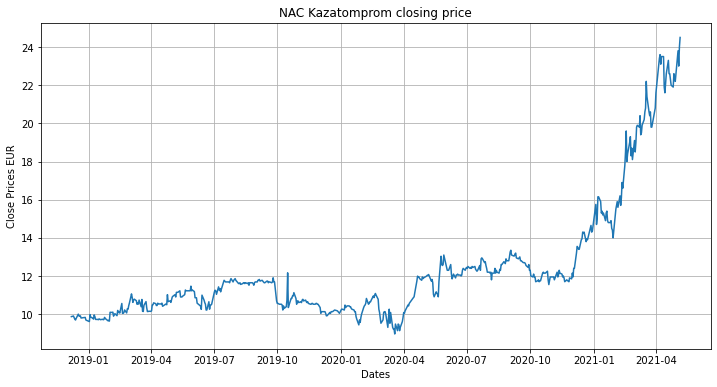

In [3]:
#Let's create a visualization that shows the daily closing price of a stock
plt.figure(figsize=(12,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices EUR')
plt.plot(df['Close'])
plt.title('NAC Kazatomprom closing price')
plt.show()

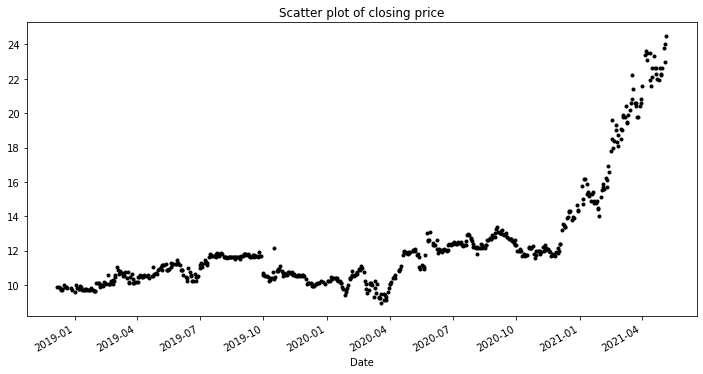

In [4]:
plt.figure(figsize=(12,6))
df_close = df['Close']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

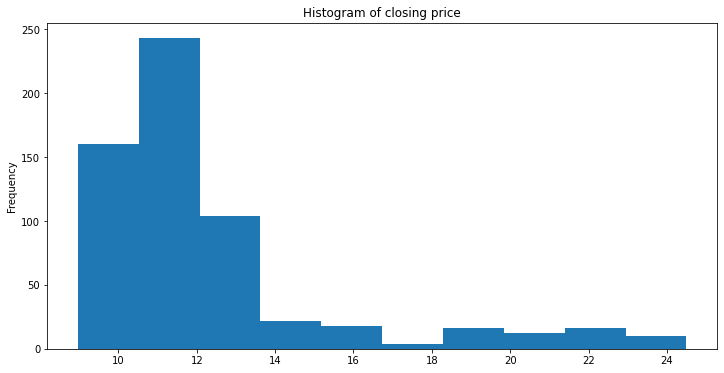

In [5]:
plt.figure(figsize=(12,6))
df_close = df['Close']
df_close.plot(style='k.',kind='hist')
plt.title('Histogram of closing price')
plt.show()

In [6]:
#Stationarity check
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

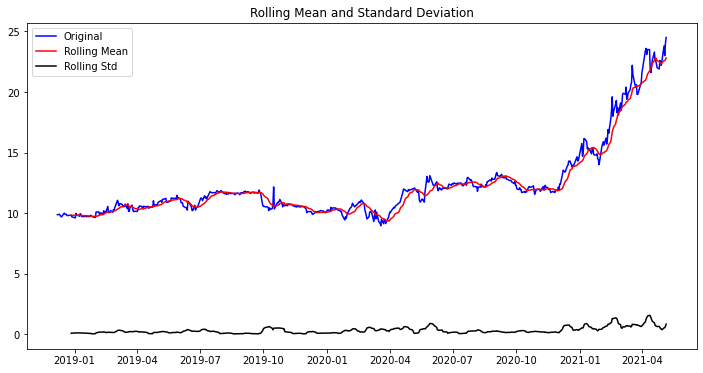

Results of dickey fuller test
Test Statistics                  3.627330
p-value                          1.000000
No. of lags used                17.000000
Number of observations used    587.000000
critical value (1%)             -3.441539
critical value (5%)             -2.866476
critical value (10%)            -2.569399
dtype: float64


In [9]:
test_stationarity(df['Close'])

<Figure size 864x432 with 0 Axes>

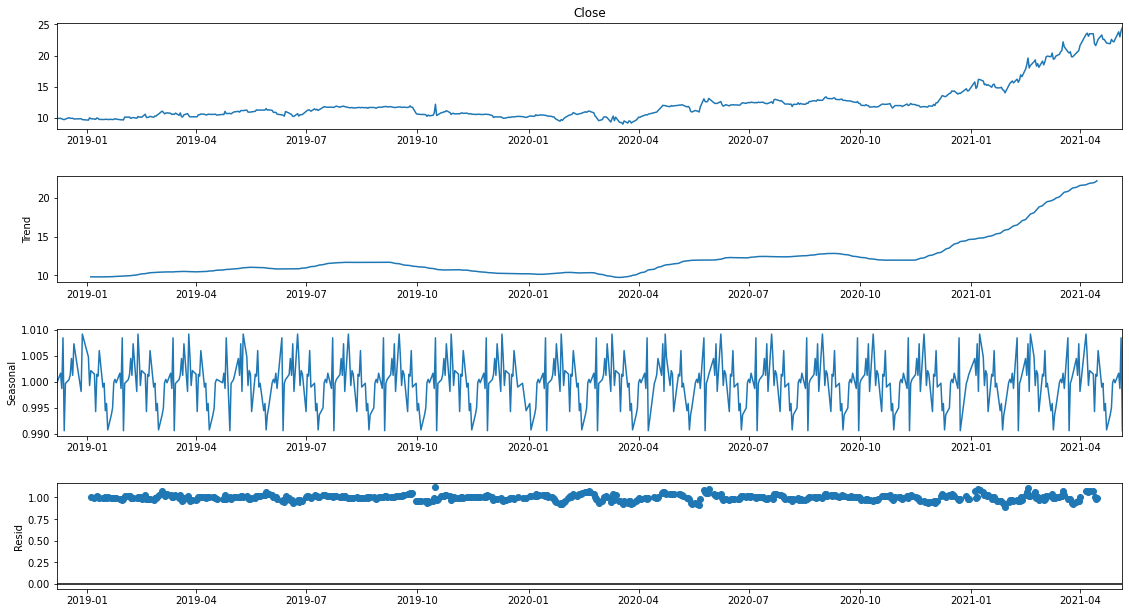

In [10]:
#Separate Trend and Seasonality from the time series
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


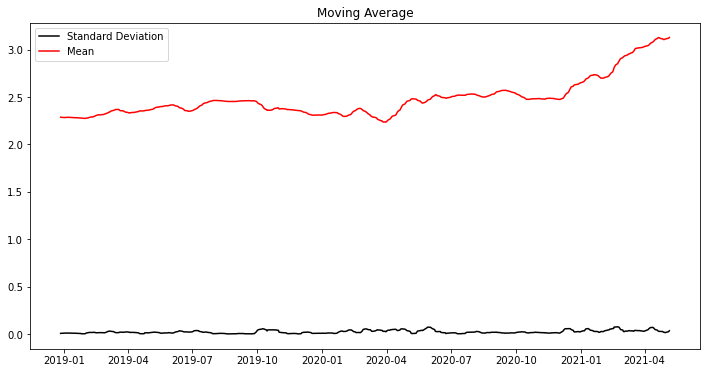

In [11]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 6
df_log = np.log(df['Close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

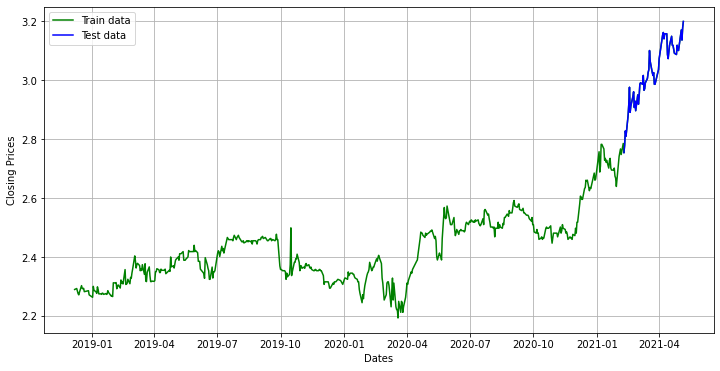

In [13]:
#Divide the data into training and test sets and visualize them
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(12,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [14]:
#ARIMA
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
test='adf',       # use adftest to find optimal 'd'
max_p=3, max_q=3, # maximum p and q
m=1,              # frequency of series
d=None,           # let model determine 'd'
seasonal=False,   # No Seasonality
start_P=0, 
D=0, 
trace=True,
error_action='ignore',  
suppress_warnings=True, 
stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2572.114, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2592.366, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2594.434, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2573.146, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2592.455, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2592.539, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2590.547, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2594.833, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2592.838, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-2592.902, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2592.945, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-2590.901, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.832 seconds
                               SARIMAX Results                              

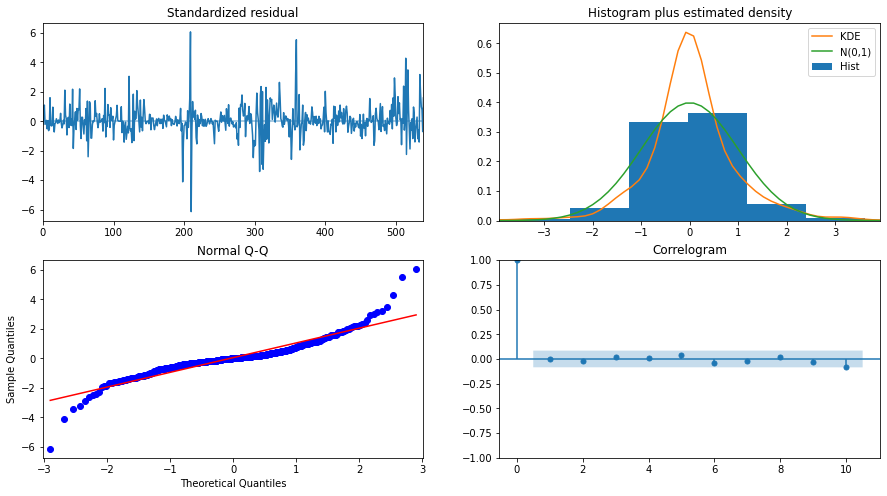

In [15]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [16]:
model = ARIMA(train_data, order=(3, 1, 2))
fitted = model.fit(disp=-1)
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  540
Model:                 ARIMA(3, 1, 2)   Log Likelihood                1304.877
Method:                       css-mle   S.D. of innovations              0.022
Date:                Fri, 07 May 2021   AIC                          -2595.753
Time:                        12:25:33   BIC                          -2565.712
Sample:                             1   HQIC                         -2584.004
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0009      0.001      1.215      0.224      -0.001       0.002
ar.L1.D.Close     0.1853      0.048      3.839      0.000       0.091       0.280
ar.L2.D.Close    -0.9103      0.020    -

In [17]:
#Forecast
fc, se, conf = fitted.forecast(61, alpha=0.05)

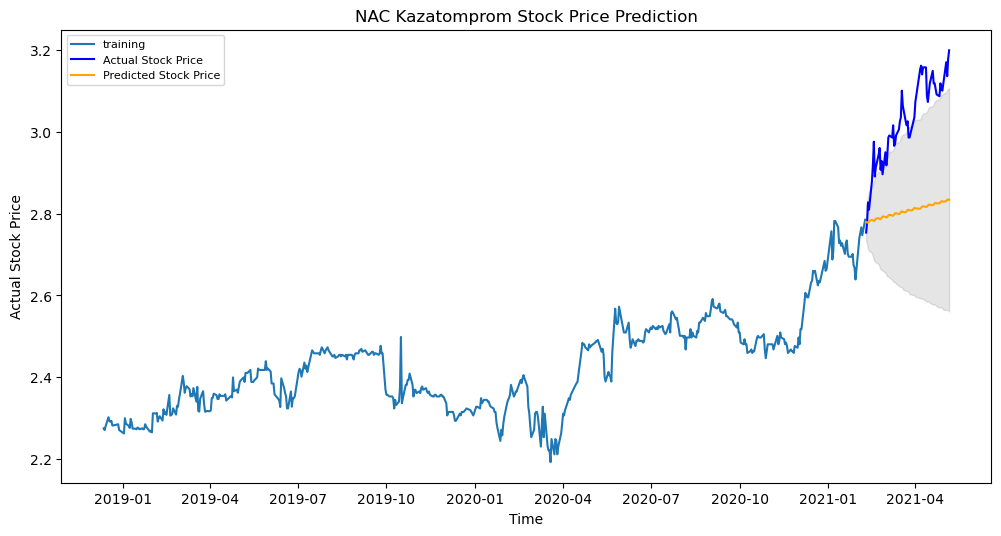

In [18]:
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,6), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('NAC Kazatomprom Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [19]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.055140061617211536
MAE: 0.21827134243273755
RMSE: 0.23481921049439616
MAPE: 0.0712815647846394


In [20]:
#Around 7% MAPE(Mean Absolute Percentage Error) implies the model is about 93.0% 
#accurate in predicting the test set observations.